In [1]:
using DelimitedFiles
using Statistics
using StatsBase

include("../src/bin.jl")
include("../src/config.jl")
include("../src/crustDistribution.jl")
include("../src/invertData.jl")

using StatGeochem
using Plots; gr();

Loading crust information from file ../resources/crustDistribution.jld


In [2]:
build_args = readdlm("../data/huang/vp_rejection/inversion_options.csv", ',', header=false)
N = build_args[findfirst(isequal("num_invert"), build_args[:,1]),2]
M = build_args[findfirst(isequal("num_runs"), build_args[:,1]),2]


1000

In [3]:
function find_age_aves(files, N, M)
	age_model = EarthChemAge(10, 3) # Default in inversion_binned_geotherm 
	ages = ageBins(age_model) 

	
    age_median = Array{Float64, 2}(undef, 3, length(ages)-1) # (layer, age)
	age_low = Array{Float64, 2}(undef, 3, length(ages)-1) # (layer, age)
	age_high = Array{Float64, 2}(undef, 3, length(ages)-1) # (layer, age) # 95 percentile


	for (l, file) in enumerate(files)	
		layer = LAYER_NAMES[l]

		(result, header) = readdlm(file, ',', header=true)
		header = header[:] # make 1d 

		si_index = findfirst(isequal("SiO2"), header) # result 
		age_index = findfirst(isequal("sample_age"), header) # Age 

		for (i, age) in enumerate(ages[1:end-1])
			mc_avgs = fill(NaN, M)
			for m in 1:M
				# only this run 
				istart = (m-1)*N + 1
				iend = m*N
                
				dat = result[istart:iend, :]

                good = ((.~isnan.(dat[:,si_index])) .& (.~isnan.(dat[:,age_index])))
				test = (dat[:,age_index] .>= age) .& (dat[:,age_index] .< ages[i+1]) .& good
                mc_avgs[m] = nanmean(convert(Array{Float64,1}, dat[test,si_index]))
            end
            
            check = .! isnan.(mc_avgs)
            age_median[l,i] = median(mc_avgs[check])
            age_low[l,i] = percentile(mc_avgs[check], 25)
            age_high[l,i] = percentile(mc_avgs[check], 75)
		end 
	end
	return ages, age_median, age_low, age_high
end 

find_age_aves (generic function with 1 method)

In [4]:
files = ["../data/huang/vp_rejection/results-$layer.csv" for layer in LAYER_NAMES]
ages, age_results, age_low, age_high = find_age_aves(files, N, M)

Using EarthChem age model


(0.0:400.0:4000.0, [66.65228336538462 66.88002142857144 … 66.27189 66.56454333333333; 65.86543731060607 65.7954471875 … 66.789459 67.65078; 59.335768761312224 58.87486666666666 … 62.43287857142857 61.845862499999996], [65.49104764423076 64.43081904166667 … 62.11374000000001 59.43124875; 64.45910957298136 63.338256750000006 … 62.7591225 61.131145; 58.03781801495017 56.80740095238096 … 58.5444655 56.4385925], [67.81634901470588 69.156815 … 69.97560200000001 72.0900985; 67.12353466304347 68.03010114583334 … 71.12969666666666 72.74155; 60.529240565856774 60.96858625 … 66.06447404761906 67.846465])

In [5]:
p1 = plot(legend=false, ylabel="% SiO2", ylims=(52, 70), title="Upper", titlefontsize=11) 
p2 = plot(legend=:bottomright, legendfontsize=7, fg_legend = :transparent, ylabel="% SiO2", ylims=(52, 70), title="Middle", titlefontsize=11)
p3 = plot(legend=false, xlabel="Age", ylabel="% SiO2", ylims=(52, 70), title="Lower", titlefontsize=11)
ps = [p1, p2, p3]

p = plot(size=(550,400), legend=:bottomright, fg_legend = :transparent, framestyle=:box, xlabel="Age", ylabel="SiO2 (weight %)");

for i in 1:3 # layers 
	color = [:blue, :orange, :green][i]
    plot!(p, ages[1:end-1].+i*10, age_results[i,:], 
        ribbon=(age_results[i,:].-age_low[i,:], age_high[i,:].-age_results[i,:]), 
        label=LAYER_NAMES[i], markerstrokecolor=color, fillalpha=.35,
        marker=true, markersize=3,
		linecolor=color, markercolor=color)
end 

In [6]:
# Plot exposed. Always use base so have same comparison... 
# TODO this will need to change when re-do base w new elts
tmin = 0
tmax = 4000
nbins = 5
samplePath = "../data/huang/bsr_ignmajors_1.csv"
ign, h = readdlm(samplePath, ',', header=true)
age_i = findfirst(isequal("Age"),PERPLEX_ELEMENTS)
si_i = findfirst(isequal("SiO2"),PERPLEX_ELEMENTS)
original = matread(IGN_FILE)
age_centers, elt_means, elt_errors = bin(ign[:,age_i], ign[:,si_i],
        tmin, tmax, length(ign[si_i])/length(original["SiO2"]), nbins)

#plot!(ps[1], age_centers, elt_means, color=:pink, 
#	yerror=elt_errors, label="exposed", markerstrokecolor=:auto);
#plot!(p, age_centers, elt_means, color=:black, 
#	 label="exposed", markerstrokecolor=:auto);

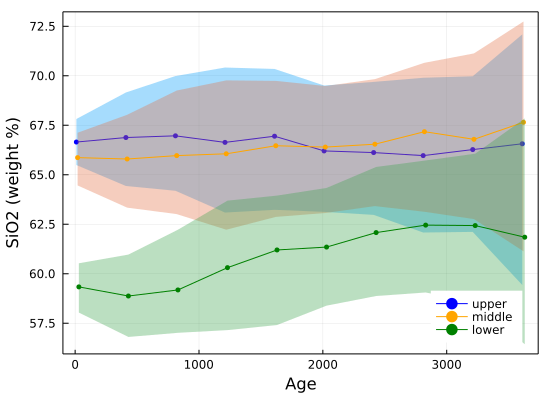

In [7]:
p

In [49]:
#savefig(p, "../../THESIS/thesis/figures/age_comp.png")

In [50]:
age_low

3×10 Matrix{Float64}:
 57.8516  56.6261  55.4923  54.9771  …  55.4642  54.5897  54.4692  53.4021
 58.5141  57.5843  57.6205  56.603      57.2379  57.3475  57.5173  56.0467
 54.4951  54.2128  54.4987  54.64       55.477   55.3418  54.925   54.5752

In [51]:
age_high

3×10 Matrix{Float64}:
 59.9832  60.382   60.7582  60.8484  …  60.8194  60.6405  60.5709  62.3032
 60.6396  61.0411  61.776   62.2483     61.9223  62.7386  63.037   64.0795
 56.6735  57.5772  58.506   59.042      60.2505  60.398   59.7702  61.6953

In [52]:
age_results

3×10 Matrix{Float64}:
 58.9784  58.531   58.1566  58.0535  …  58.0876  57.784   57.7108  58.2063
 59.6288  59.3567  59.7007  59.5712     59.6733  60.2614  60.1863  60.3538
 55.6071  55.9484  56.6084  56.9909     57.7546  57.785   57.5156  58.2169

In [8]:
name = "huang/vp_rejection"

"huang/vp_rejection"

In [9]:
ures, h = readdlm("../data/$name/results-upper.csv", ',', header=true)
mres, h = readdlm("../data/$name/results-middle.csv", ',', header=true)
lres, h = readdlm("../data/$name/results-lower.csv", ',', header=true)

([2924.525933338861 6.935835628803668 … 0.0 3.0; 2919.0822776757905 6.887450820723168 … 0.0 2.0; … ; 2904.260601023081 6.811819268716205 … 0.0 4.0; 2911.1542894108325 6.811024641248022 … 0.0 4.0], AbstractString["sample_rho" "sample_vp" … "exhumed" "bin"])

In [10]:
si_i = findfirst(isequal("SiO2"), h[:]);

In [11]:
resu = zeros(M,3)

for (l, res) in enumerate([ures, mres, lres])
    for i in 1:M
        istart = (i-1)*N + 1
        iend = i*N
        #println(nanmean(res[istart:iend, si_i]))
        resu[i,l] = nanmean(
            convert(Array{Float64,1}, res[istart:iend, si_i]))
    end
end

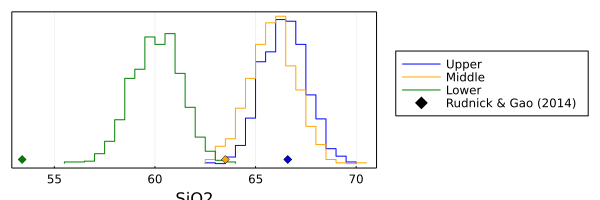

In [12]:
colors = [:blue, :orange, :green]
stephist(resu[:,1], normalize=:pdf, label="Upper", c=colors[1])
stephist!(resu[:,2], normalize=:pdf, label="Middle", c=colors[2])
stephist!(resu[:,3], normalize=:pdf, label="Lower", c=colors[3])
scatter!([66.6], [1/100], c=:black, shape=:diamond, label="Rudnick & Gao (2014)", legend=:outerright)
scatter!([66.6], [1/100], c=colors[1], label=false, shape=:diamond)
scatter!([63.5], [1/100], c=colors[2], label=false, shape=:diamond)
scatter!([53.4], [1/100], c=colors[3], label=false, shape=:diamond)
plot!(yticks=false, framestyle=:box, xlabel="SiO2", size=(600, 200))
#savefig("../../THESIS/thesis/figures/comp.png")

In [13]:
age_low


3×10 Matrix{Float64}:
 65.491   64.4308  64.1901  63.0901  …  62.9733  62.0824  62.1137  59.4312
 64.4591  63.3383  63.0118  62.2239     63.4169  63.1283  62.7591  61.1311
 58.0378  56.8074  57.0162  57.1528     58.8758  59.0539  58.5445  56.4386